In [32]:
import torch
from pathlib import Path
from pydicom import dcmread
from PIL import Image
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Get all the train data samples and test data samples path as list

data_file = Path('data/pneumonia_dataset')

train_path = list(data_file.glob('stage_2_train_images/*.dcm'))
test_path = list(data_file.glob('stage_2_test_images/*.dcm'))
print(f'Train Data Images: {len(train_path)}')
print(f'Test Data Images: {len(test_path)}')

Train Data Images: 26684
Test Data Images: 3000


In [9]:
# Split the total data of 26684 into train and val dataset for YOLOv8
train_size = 20000


yolo_train_path = train_path[0: 20000]
val_path = train_path[20000:]

print(f'YOLO Train Data Samples: {len(yolo_train_path)}')
print(f'YOLO val Data Samples: {len(val_path)}')

YOLO Train Data Samples: 20000
YOLO val Data Samples: 6684


In [18]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


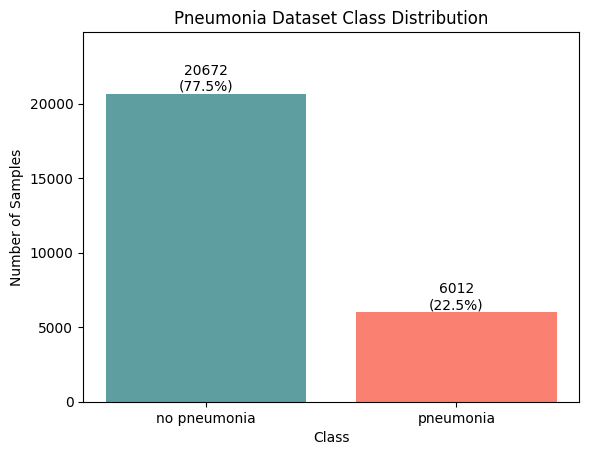

In [135]:
# Number of Data samples with pneumonia and without pneumonia

counts = label_csv.drop_duplicates('patientId')['Target'].value_counts()

# num_no_pneumonia = counts[0]
# num_pneumonia = counts[1]

data_class = {
    'no pneumonia': int(counts.get(0, 0)),
    'pneumonia': int(counts.get(1, 0))
}

total = sum(data_class.values())


bars = plt.bar(data_class.keys(), data_class.values(), color=['cadetblue', 'salmon'])
plt.bar_label(bars, labels=[f"{value}\n({value/total*100:.1f}%)" for value in data_class.values()])
plt.ylim(0, 1.2*max(data_class.values()))
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Pneumonia Dataset Class Distribution')
plt.show()


In [141]:
# Check if neumonia cases vary by metadata like (age, sex, image view)

data = dcmread(train_path[0])
data

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                  

In [10]:
def dcm_to_jpg(dcm_path, save_path):
    '''
    Convert a DICOM (.dcm) file to a JPEG (.jpg) file and save it.

    This function reads a DICOM file from `dcm_path`, converts the pixel data
    to an image, and saves the image as a JPEG file at `save_path`.

    Args:
        dcm_path (str): File path of the input DICOM file.
        save_path (str): File path to save the output JPEG file.

    Returns:
        None
    '''
    save_path = Path(save_path)

    if not save_path.is_dir():
        dcm_data = dcmread(dcm_path)
        dcm_pixel_array = dcm_data.pixel_array
        image = Image.fromarray(dcm_pixel_array)
        image.save(save_path, 'JPEG')


In [11]:
# Create YOLO File format list

yolo_file_format = ['YOLO_format_data', ['images', 'labels', 'data.yaml'], ['train', 'val']]

# Create the YOLO file format directory
for x in range(2):
    for y in range(2):
        form_path = os.path.join(yolo_file_format[0], yolo_file_format[1][x], yolo_file_format[2][y])
        form_path = Path(form_path)
        form_path.mkdir(parents=True, exist_ok=True)

# # Create data.yaml file
yaml_file = Path(yolo_file_format[0]) / yolo_file_format[1][2]

# Content for the data.yaml file as required by the YOLO model
yaml_content = {
    'train': f'{yolo_file_format[1][0]}/{yolo_file_format[2][0]}',
    'val': f'{yolo_file_format[1][0]}/{yolo_file_format[2][1]}',
    'nc': 1,
    'names': ['pneumonia']
}

# write the content into the data.yaml file
with open(yaml_file, 'w') as file:
    yaml.dump(yaml_content, file)

In [12]:
# Save all the training images into the images direcotry

train_image_name_list = []
for x in range(len(yolo_train_path)):
    img = f'img{x+1}.jpg'
    train_image_name_list.append(img)

train_yolo_img = Path('YOLO_format_data/images/train')



for index, path in enumerate(yolo_train_path):
    save_path = os.path.join(train_yolo_img, train_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)



In [13]:
# Save all the val images into the val directory

val_image_name_list = []
cont = len(train_image_name_list)
cont
for x in range(len(val_path)):
    img = f'img{cont+x+1}.jpg'
    val_image_name_list.append(img)

val_yolo_img = Path('YOLO_format_data/images/val')

for index, path in enumerate(val_path):
    save_path = os.path.join(val_yolo_img, val_image_name_list[index])
    dcm_to_jpg(dcm_path=path, save_path=save_path)

In [14]:
# File path of the labels from the working data and convert the csv file into a pandas DataFrame

label_file_path = 'data/pneumonia_dataset/stage_2_train_labels.csv'
label_csv = pd.read_csv(label_file_path)
label_csv

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
...,...,...,...,...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,NaN,NaN,NaN,NaN,0
30224,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [15]:
# Create a list of all the txt files names for train labels file

train_image_txt_list = []

for image_name in train_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    train_image_txt_list.append(txt_fil_name)

In [16]:
# File path to save the train labels file to
labels_train = Path('YOLO_format_data/labels/train')


# Iterate over each path from the list of training data path
for index, path in enumerate(yolo_train_path):

    # Patient Id of the instance of data 
    id = path.stem
    # Get all the label data associated with the Id
    bbox_data = label_csv[label_csv['patientId'] == id] 

    # final file path to save the instance of label data to
    labels_train_txt = os.path.join(labels_train, train_image_txt_list[index])

    # Create a  label file for each image data
    with open(labels_train_txt, 'w') as f:
        # write label into the file if the bbox for the image exists 
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

In [17]:
# Create a list of all the txt files names for val labels file

val_image_txt_list = []

for image_name in val_image_name_list:
    image_name = Path(image_name)
    name = image_name.stem
    txt_fil_name = f'{name}.txt'
    val_image_txt_list.append(txt_fil_name)

In [18]:
labels_val = Path('YOLO_format_data/labels/val')

x = 0
for index, path in enumerate(val_path):
    id = path.stem
    bbox_data = label_csv[label_csv['patientId'] == id]

    labels_train_txt = os.path.join(labels_val, val_image_txt_list[index])

    with open(labels_train_txt, 'w') as f:
        if bbox_data.iloc[0, 5].item() == 1:
            label_class_id = bbox_data.iloc[0, 5].item()
            for x in range(len(bbox_data)):
                x1 = bbox_data.iloc[x, 1].item() / 1024
                y1 = bbox_data.iloc[x, 2].item() / 1024
                width = bbox_data.iloc[x, 3].item() / 1024
                height = bbox_data.iloc[x, 4].item() / 1024
                f.write(f'{label_class_id-1} {x1} {y1} {width} {height}')
                f.write('\n')
        # Write nth into the file if no bbox for the instance of data exist
        else:
            pass

    # break
    

# Workign with the data part is done...now fine tuning the model part


In [19]:
from ultralytics import YOLO

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
model = YOLO('yolov8n.pt')

In [22]:
train_results = model.train(
    data='YOLO_format_data/data.yaml',
    epochs=5,
    imgsz=640,
    batch=16,
    name='medical_imaging'
)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imaging, nbs=64, nms=False, opset=None, opt

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:18<00:00, 1102.88it/s]


train: New cache created: C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache
val: Fast image access  (ping: 0.10.1 ms, read: 4.40.9 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:05<00:00, 1143.52it/s]


val: New cache created: C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache
Plotting labels to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\medical_imaging\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to c:\Users\w10195102\Desktop\PROJECTS\ML_Projects\runs\detect\medical_imaging
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      3.82G      2.372      4.695      2.326         14        640: 100%|██████████| 1250/1250 [21:50<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:59<00:00,  1.17it/s]


                   all       6684       1359      0.007       0.71     0.0475     0.0153

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.84G      2.185      3.388       2.17         11        640: 100%|██████████| 1250/1250 [22:09<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:09<00:00,  1.10it/s]


                   all       6684       1359     0.0674      0.231     0.0525     0.0172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G        2.1      3.194        2.1         14        640:  78%|███████▊  | 973/1250 [16:28<04:41,  1.02s/it]


KeyboardInterrupt: 

In [ ]:
# len(yolo_train_path)
# x = dcmread(yolo_train_path[3])
# shape = x.pixel_array.shape
# for x in shape:
#     print(x)


# for index, path in enumerate(yolo_train_path):
#     data = dcmread(path)
#     image_shape = data.pixel_array.shape
#     for x in image_shape:
#         if x != 1024:
#             print(index)
#             break

1024
1024


Great — since you're training YOLOv8 in a Python notebook using the Ultralytics library, here's exactly how to safely stop training and resume it later.

✅ How to Stop Training Safely
You can interrupt the notebook kernel (or click the stop button), and YOLOv8 will automatically save the last checkpoint.

By default, it saves to:

swift
Copy
Edit
runs/detect/train/weights/last.pt
✅ How to Resume Training Later
In a new cell, just run:

python
Copy
Edit
from ultralytics import YOLO

# Load from the last saved checkpoint
model = YOLO('runs/detect/train/weights/last.pt')

# Resume training
model.train(resume=True)
This resumes:

Optimizer state

Epoch count

Best weights

All hyperparameters

🔁 Optional: Resume with Adjustments
Want to change something (e.g., number of total epochs)?

python
Copy
Edit
model.train(resume=True, epochs=100)
YOLO will pick up where it left off and continue up to 100 total epochs.

📁 Where Your Checkpoints Are Saved
Each training run creates a directory like:

bash
Copy
Edit
runs/detect/train/  # or train2, train3, etc.
Inside that, you'll see:

weights/last.pt – the latest checkpoint

weights/best.pt – the best performing model so far

results.csv – your training logs

💡 Pro Tip: Set a Custom Save Path
To avoid confusion across multiple runs:

python
Copy
Edit
model.train(data='data.yaml', epochs=100, name='rsna_pneumonia_run1')
This saves to:

bash
Copy
Edit
runs/detect/rsna_pneumonia_run1/
Let me know if you'd like to auto-resume from the best model or evaluate your current checkpoint!

In [ ]:
# Continue training the mdoel form where it left of last time

from ultralytics import YOLO

model = YOLO('runs/detect/medical_imaging_v22/weights/last.pt')

In [2]:
model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\medical_imaging_v22\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 212.5133.7 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v22\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs\detect\medical_imaging_v22\weights\last.pt from epoch 2 to 5 total epochs
Closing dataloader mosaic
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v22
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.85G      1.941       2.92      1.999         14        640: 100%|██████████| 1250/1250 [21:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:00<00:00,  1.16it/s]


                   all       6684       1359      0.161      0.194      0.101     0.0321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.84G      1.961      2.937      2.002         11        640: 100%|██████████| 1250/1250 [21:56<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:07<00:00,  1.11it/s]

                   all       6684       1359      0.236      0.162      0.122     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.83G      1.931      2.872      1.981         28        640: 100%|██████████| 1250/1250 [21:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:08<00:00,  1.11it/s]


                   all       6684       1359      0.173      0.283      0.114     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.84G      1.878      2.784      1.939          8        640: 100%|██████████| 1250/1250 [21:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:10<00:00,  1.10it/s]

                   all       6684       1359      0.295      0.241      0.206     0.0731



4 epochs completed in 1.640 hours.
Optimizer stripped from runs\detect\medical_imaging_v22\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\medical_imaging_v22\weights\best.pt, 6.2MB

Validating runs\detect\medical_imaging_v22\weights\best.pt...
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [01:46<00:00,  1.96it/s]


                   all       6684       1359      0.296      0.241      0.206      0.073
Speed: 0.5ms preprocess, 14.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\medical_imaging_v22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001E0815BE060>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [3]:

model = YOLO('runs/detect/medical_imaging_v2/weights/best.pt')

model.train(data='YOLO_format_data/data.yaml', epochs=20, project='runs/detect', name='medical_imaging_v3')


New https://pypi.org/project/ultralytics/8.3.146 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/medical_imaging_v2/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 448.9233.3 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.84G      1.819       2.71      1.894         14        640: 100%|██████████| 1250/1250 [22:20<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:39<00:00,  1.31it/s]

                   all       6684       1359      0.185      0.238      0.124     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.84G      1.907      2.837      1.955         11        640: 100%|██████████| 1250/1250 [20:54<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:04<00:00,  1.13it/s]

                   all       6684       1359      0.299       0.25       0.18     0.0624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.83G      1.966      2.918      1.994         28        640: 100%|██████████| 1250/1250 [20:57<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:57<00:00,  1.18it/s]


                   all       6684       1359      0.224       0.18       0.12      0.041

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.84G      1.962      2.903      1.983          8        640: 100%|██████████| 1250/1250 [20:13<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:06<00:00,  1.12it/s]

                   all       6684       1359      0.286      0.252      0.177     0.0588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.84G      1.959      2.851      1.988          4        640: 100%|██████████| 1250/1250 [22:05<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:58<00:00,  1.17it/s]


                   all       6684       1359      0.229       0.28      0.172     0.0623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.84G       2.01      2.858      1.989          6        640:   4%|▍         | 52/1250 [00:53<20:36,  1.03s/it]


KeyboardInterrupt: 

In [1]:
from ultralytics import YOLO

model = YOLO('runs/detect/medical_imaging_v3/weights/last.pt')

In [2]:
model.train(resume=True)

New https://pypi.org/project/ultralytics/8.3.147 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.145  Python-3.13.1 torch-2.6.0+cu126 CUDA:0 (NVIDIA T400 4GB, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=YOLO_format_data/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\medical_imaging_v3\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=medical_imagin

train: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\train.cache... 20000 images, 14917 backgrounds, 0 corrupt: 100%|██████████| 20000/20000 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.1 ms, read: 179.680.3 MB/s, size: 57.1 KB)


val: Scanning C:\Users\w10195102\Desktop\PROJECTS\ML_Projects\Medical_Image_Classification\YOLO_format_data\labels\val.cache... 6684 images, 5755 backgrounds, 0 corrupt: 100%|██████████| 6684/6684 [00:00<?, ?it/s]


Plotting labels to runs\detect\medical_imaging_v3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training runs\detect\medical_imaging_v3\weights\last.pt from epoch 13 to 20 total epochs
Closing dataloader mosaic
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\medical_imaging_v3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.85G      1.805      2.656      1.872         14        640: 100%|██████████| 1250/1250 [20:40<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:56<00:00,  1.19it/s]

                   all       6684       1359      0.328      0.258       0.22     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.83G      1.784       2.59      1.856         11        640: 100%|██████████| 1250/1250 [21:32<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:05<00:00,  1.13it/s]

                   all       6684       1359        0.3      0.307      0.229     0.0809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.83G      1.767      2.584      1.846         28        640: 100%|██████████| 1250/1250 [20:18<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:44<00:00,  1.27it/s]

                   all       6684       1359      0.339      0.322      0.259     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.83G       1.75      2.544      1.834          8        640: 100%|██████████| 1250/1250 [19:49<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [03:06<00:00,  1.12it/s]

                   all       6684       1359      0.322      0.298      0.249     0.0869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.83G      1.736      2.512      1.822          4        640: 100%|██████████| 1250/1250 [21:03<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 209/209 [02:56<00:00,  1.19it/s]

                   all       6684       1359      0.296       0.32      0.238     0.0859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.83G      1.781      2.553      1.861          9        640:  77%|███████▋  | 963/1250 [16:05<04:47,  1.00s/it]


KeyboardInterrupt: 

Thanks for sharing your full data preparation pipeline — you've clearly put considerable effort into preparing the RSNA Pneumonia dataset for YOLOv8, and your code is mostly well-structured, functional, and thoughtful. Below is a detailed and structured review of your work, highlighting what you did well, what can be improved, and recommendations for enhancement from both engineering and machine learning perspectives.

✅ What You Did Well
1. Data Pipeline Structure & Clarity
You follow a logical, modular structure — separating stages like DICOM to JPEG conversion, label processing, directory setup, and YAML generation.

Clear and consistent naming conventions: Your use of variables like train_image_name_list, val_image_txt_list, etc., makes the code easy to follow.

2. Proper DICOM Handling
The use of pydicom to read .dcm files and conversion to .jpg with PIL.Image is well-implemented.

You took care to extract pixel data correctly, which is essential when dealing with medical images.

3. YOLO-Compatible Dataset Formatting
You correctly created the directory structure expected by YOLOv8 (images/train, images/val, labels/train, labels/val).

Proper formatting of annotation files in YOLO format (normalized x, y, w, h) is present.

4. Basic Data Management
File existence checks and directory creation with mkdir(..., exist_ok=True) are good defensive programming practices.

Usage of Python's Path and os modules is appropriate for filesystem handling.

⚠️ Areas of Improvement
1. Code Efficiency and Readability
🔸 Avoid Redundant Code
There is a lot of duplicate code between training and validation loops for:

Image conversion (dcm_to_jpg)

Label processing

Fix: Abstract these into reusable functions like:

python
Copy
Edit
def process_images(dcm_paths, save_dir, name_list):
    for idx, dcm in enumerate(dcm_paths):
        save_path = os.path.join(save_dir, name_list[idx])
        dcm_to_jpg(dcm, save_path)
🔸 Hardcoding Image Size
You hardcoded normalization with 1024:

python
Copy
Edit
x1 = bbox_data.iloc[x, 1].item() / 1024
However, DICOM images in the dataset may not all be 1024×1024.

Fix:
Dynamically extract the image shape:

python
Copy
Edit
dcm_data = dcmread(path)
height, width = dcm_data.pixel_array.shape
x1 = bbox_data.iloc[x, 1].item() / width
2. Missing Negative Class (No Pneumonia) Handling
Your label generation ignores negative samples (else: pass). These are crucial for object detection models to learn what not to detect.

Fix: Still write an empty .txt file for such images:

python
Copy
Edit
else:
    open(labels_train_txt, 'w').close()
YOLO expects a label file per image — even if it's empty.

3. Better Metadata and Logging
You’re currently not using logging for debugging or performance profiling.

Fix: Use logging module to add insight during dataset prep:

python
Copy
Edit
import logging
logging.basicConfig(level=logging.INFO)

logging.info(f'Processing image {index + 1}/{len(yolo_train_path)}')
4. Image Normalization or Contrast Handling
Medical images like DICOMs may have contrast issues. A basic .jpg conversion may cause loss of important clinical features.

Suggestion: Apply contrast enhancement / histogram equalization using cv2.equalizeHist() or SimpleITK to enhance image quality before saving to .jpg.

🧠 Deeper Machine Learning Considerations
1. Data Stratification
Your split is purely random ([:20000], [20000:]), but there may be class imbalance (i.e., many images without pneumonia). Ensure both train and val sets maintain a similar positive/negative class distribution.

Fix: Stratified splitting:

python
Copy
Edit
from sklearn.model_selection import train_test_split

df_pos = label_csv[label_csv['Target'] == 1]
df_neg = label_csv[label_csv['Target'] == 0]

train_ids, val_ids = train_test_split(df_pos['patientId'].unique(), stratify=df_pos['Target'], test_size=0.25)
2. Image Preprocessing and Augmentation
Currently, images are not preprocessed for brightness, noise, or other modalities. Consider:

Applying clahe (Contrast Limited Adaptive Histogram Equalization)

Rescaling to a standard resolution (YOLOv8 can handle this at training, but consistency helps)

Also, consider adding augmentations like:

Random flips

Rotation

Brightness adjustment

These can be done during training using YOLOv8's in-built augmentation or via Albumentations.

📦 Final Thoughts: Your Strengths & Where to Improve
✅ Strengths	⚠️ Areas to Improve
Clean structure & use of Pathlib	Duplicate code — refactor for modularity
Correct YOLO formatting & dir structure	Label processing needs better handling of negatives
Good use of CSV + Pandas	Hardcoded image shape — should be dynamic
Accurate data.yaml creation	No data stratification or class balance consideration
Working DICOM to JPEG conversion	No image contrast enhancement or medical image preprocessing

⭐ Recommendations
Refactor repetitive blocks into functions.

Handle negative (no pneumonia) examples more explicitly.

Include image shape extraction dynamically.

Log key steps and potential warnings.

Apply basic preprocessing to enhance DICOM image contrast.

Optionally, verify the YOLOv8 training quality via mAP for early feedback.

Let me know if you'd like help refactoring this into cleaner reusable functions or adding the next stage (training, evaluation, visualization, or inference)!


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


You said:
i was expecting u to give other feedback like lack of visualizing data in differnt types of graph..... and no data cleaning and stugg


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


ChatGPT said:
Great follow-up — you're absolutely right to expect feedback beyond the mechanical and code-focused aspects. Data science, especially in medical imaging, isn't just about getting the data into the right format, but also about understanding, cleaning, and validating it before training. Let’s dive deeper into what’s missing or underexplored in your pipeline from a data science, ML, and EDA (Exploratory Data Analysis) perspective.

🧠 High-Level Gaps in Your Pipeline
1. No Data Exploration or Visualization
You jumped directly into converting and formatting data, but without knowing what you’re working with, you risk feeding your model noisy, biased, or incomplete data.

🚩What You Missed:
Distribution of bounding boxes (sizes, locations)

Image modality metadata (some images might be corrupted, noisy, or extremely dark/bright)

Class imbalance (how many pneumonia vs non-pneumonia samples?)

✅ What You Could Have Done:
Visualizations that would’ve helped:

Bar chart of pneumonia vs. non-pneumonia cases

Histogram of bounding box widths/heights

Sample images with bounding boxes plotted

Image intensity histograms to inspect contrast/brightness variations

Patient age or gender distribution, if metadata is available

Example:

python
Copy
Edit
import matplotlib.pyplot as plt

label_csv['Target'].value_counts().plot(kind='bar')
plt.title('Pneumonia vs Normal Distribution')
plt.xticks([0, 1], ['No Pneumonia', 'Pneumonia'], rotation=0)
plt.ylabel('Number of Samples')
plt.show()
2. No Data Cleaning or Sanity Checks
🚩What You Missed:
Duplicated entries in the CSV? (can happen in large medical datasets)

Missing or corrupted images?

Inconsistent label coordinates (e.g., negative width/height, out-of-bound values)?

Check if all .dcm files are referenced in the CSV

✅ Checks You Could Include:
python
Copy
Edit
# Check for missing values
print(label_csv.isnull().sum())

# Ensure coordinates are valid
assert (label_csv['width'] >= 0).all()
assert (label_csv['height'] >= 0).all()

# Remove duplicate rows
label_csv = label_csv.drop_duplicates()
3. No Sanity Check on Label Mapping
You assume:

python
Copy
Edit
label_class_id = bbox_data.iloc[0, 5].item()
f.write(f'{label_class_id-1} ...')
But this only works because pneumonia is the only class and is labeled as 1 — what if there were more classes later? Or different labeling styles?

✅ More robust:
python
Copy
Edit
class_map = {1: 0}  # map pneumonia to class 0
class_id = class_map.get(label_class_id, -1)
4. No Summary Stats / Dataset Profiling
A simple summary table could give you insight like:

Avg number of bboxes per pneumonia case

% of images that have multiple boxes

Avg width/height ratio

These are super helpful for debugging model performance later.

Example:

python
Copy
Edit
pneumonia_cases = label_csv[label_csv['Target'] == 1]
avg_boxes = pneumonia_cases.groupby('patientId').size().mean()
print(f"Average boxes per pneumonia image: {avg_boxes}")
5. No Verification After Conversion
There’s no check that:

All .jpg images were saved successfully

All labels have a corresponding image

Images and labels are correctly matched by filename

Danger: Any mismatch = silent failure in YOLO training

✅ Fix:
Write a post-process checker:

python
Copy
Edit
img_files = set(f.stem for f in Path('YOLO_format_data/images/train').glob('*.jpg'))
label_files = set(f.stem for f in Path('YOLO_format_data/labels/train').glob('*.txt'))
missing_labels = img_files - label_files
print(f'Images with missing labels: {len(missing_labels)}')
6. No Metadata Use (if available)
The RSNA dataset comes with some metadata per image:

Patient ID, age, gender, view position
You didn’t use or explore any of it.

✅ Could Use For:
Stratified splitting based on demographics

Bias detection

Error analysis after training

📌 Summary of What to Improve (Broader Feedback)
Category	Gap	Suggested Action
EDA	No graphs, plots, or data exploration	Use Matplotlib/Seaborn to visualize distributions, sizes, samples
Data Cleaning	No checks for missing/corrupted data, duplicates, bad coordinates	Add sanity checks, remove bad samples
Class Balance	Assumed balanced split, no stratification	Count and balance samples explicitly
Data Verification	No check that every image has a label and vice versa	Post-process validation code
Metadata Use	Ignored demographic and acquisition metadata	Explore metadata for patterns, fairness, or stratified split
Bounding Box Quality	Didn't visualize any sample with bounding box	Plot a few random images + boxes for confirmation
Image Preprocessing	No normalization, contrast enhancement	Enhance contrast using cv2 or SimpleITK
Automation & Reusability	Lots of duplicate code across train/val sections	Refactor into reusable functions

🎯 Final Suggestion
Before training, it’s a good idea to create a visual data report or even a Jupyter notebook for:

EDA graphs

Sample visualizations (DICOM + boxes)

Class balance summary

Bounding box heatmaps (using seaborn or matplotlib)

Let me know if you want help creating these EDA plots or adding sanity checks — I can write some ready-to-use code for that.